In [1]:
import sys
sys.path.append('/home/kyungtak.lim/gbspy')
#from skimage.measure import label, regionprops

In [2]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as mcolors

from scipy.stats import skew, kurtosis

#import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

In [17]:
os.chdir('/zhisongqu_data/kyungtak/data_GBS/GBS_SN/nu_scan/SN_nu1')
s=g.Sim()

t_final = s.time[-1]
t_init = t_final

dens = s.get_field('n', t1=t_init, t2=t_final)
#tempe = s.get_field('temperature', t1=t_init, t2=t_final)
#pe = dens * tempe
#tempi = s.get_field('temperaturi', t1=t_init, t2=t_final)
strmf = s.get_field('strmf', t1=t_init, t2=t_final)
#omega = s.get_field('omega', t1=t_init, t2=t_final)
#vpari = s.get_field('vpari', t1=t_init, t2=t_final)
#vpare = s.get_field('vpari', t1=t_init, t2=t_final)

# Density
dens_avg  = np.mean(dens, axis=(2,3)); 
dens_std  = np.std(dens, axis=(2,3))
dens_avg_tor = np.mean(dens, axis=2)

# Normalized
dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
#dens_fluct = dens[:,:,0,-1] - dens_avg
dens_fluct_avg = np.mean(dens_fluct, axis=2)

strmf_avg  = np.mean(strmf, axis=(2,3)); 
strmf_std  = np.std(strmf, axis=(2,3))
strmf_avg_tor = np.mean(strmf, axis=2)

# Normalized
strmf_fluct   = np.sqrt((strmf[:,:,0,:]-strmf_avg_tor)**2) / strmf_avg_tor
#strmf_fluct = strmf[:,:,0,-1] - strmf_avg
strmf_fluct_avg = np.mean(strmf_fluct, axis=2)


#tempe_avg = np.mean(tempe, axis=(2,3))
#pe_avg    = np.mean(pe, axis=(2,3))
#tempi_avg = np.mean(tempi, axis=(2,3))
#strmf_avg = np.mean(strmf, axis=(2,3))
#omega_avg = np.mean(omega, axis=(2,3))
#vpari_avg = np.mean(vpari, axis=(2,3))
#vpare_avg = np.mean(vpare, axis=(2,3))


Xxpt = s.xxpt
Yxpt = s.yxpt
xmag = s.x0
ymag = s.y0
Psi = s.Psi
Bpol = s.dpsidx_v**2 + s.dpsidy_v**2
Xpt_coord = np.unravel_index(np.argmin(Bpol[Bpol > 0]), s.dpsidx_v.shape)

In [18]:
dens_fluct_avg.shape

(324, 244)

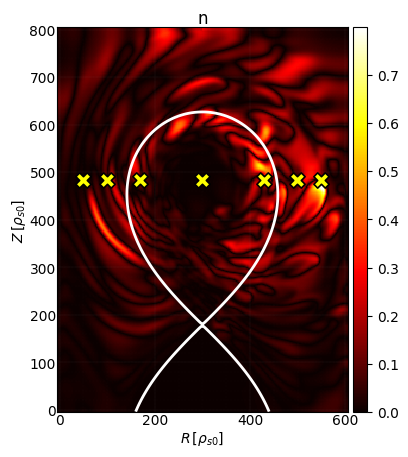

In [19]:
X, Y = np.meshgrid(s.x, s.y)
fig, ax = plt.subplots(figsize=(4, 5), sharex=True, sharey=True)

cs1 = ax.pcolormesh(X, Y, dens_fluct_avg, cmap='hot')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(cs1, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)


ax.contour(X, Y, Psi, levels=[Psi[s.iyxpt, s.ixxpt]], colors='w', linewidths=2)
ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
ax.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', labelsize=10, pad=1)
ax.tick_params(axis='y', labelsize=10, pad=1)
ax.tick_params(which='minor', direction="in", size=0)
ax.tick_params(which='major', direction="in", size=0)

ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=10, labelpad=1)
ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=10, rotation=90, labelpad=1)

# Several points
ax.scatter(s.x0, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0-130, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0-200, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0-250, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0+130, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0+200, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)
ax.scatter(s.x0+250, s.y0, s=120, color='yellow', marker='X', edgecolor='k', linewidth=1.2)


ax.set_title(r'n', fontsize=12, pad=1.5)

#plt.gca().set_aspect('equal')
plt.show(block=False)

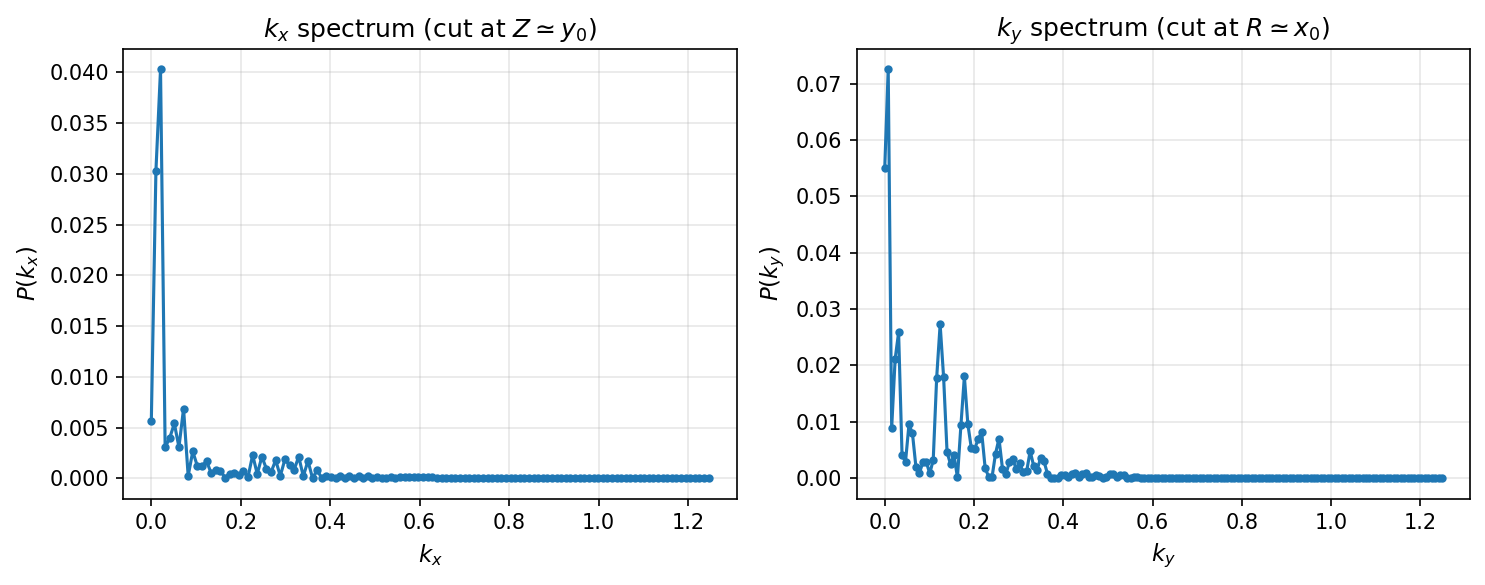

In [23]:
# ----------------------------------------------------
# 0) Choose which field to analyze
# ----------------------------------------------------
# For density:
field = dens_fluct_avg        # shape (ny, nx)

# For potential instead, just do:
#field = strmf_fluct_avg

ny, nx = field.shape
x = s.x      # R-grid (nx,)
y = s.y      # Z-grid (ny,)

dx = float(x[1] - x[0])
dy = float(y[1] - y[0])

# ----------------------------------------------------
# 1) Choose lines for kx and ky spectra
# ----------------------------------------------------
# For kx: take a horizontal cut at Z ≈ s.y0 (midplane)
iy_mid = np.argmin(np.abs(y - s.y0))
profile_x = field[iy_mid, :]            # (nx,)

# For ky: take a vertical cut at R ≈ s.x0 (magnetic axis, or choose another R)
ix_mid = np.argmin(np.abs(x - (s.x0+100)))
profile_y = field[:, ix_mid]            # (ny,)

# Remove mean to avoid strong k=0 in spectra
profile_x = profile_x - profile_x.mean()
profile_y = profile_y - profile_y.mean()

# Optional: apply window to reduce spectral leakage
win_x = np.hanning(nx)
win_y = np.hanning(ny)

profile_x_w = profile_x * win_x
profile_y_w = profile_y * win_y

# ----------------------------------------------------
# 2) FFT → kx, ky spectra
# ----------------------------------------------------
# FFT along R → kx
Fkx = np.fft.fft(profile_x_w)
kx  = 2.0 * np.pi * np.fft.fftfreq(nx, d=dx)

Pkx = (np.abs(Fkx)**2) / nx      # simple PSD estimate

# FFT along Z → ky
Fky = np.fft.fft(profile_y_w)
ky  = 2.0 * np.pi * np.fft.fftfreq(ny, d=dy)

Pky = (np.abs(Fky)**2) / ny

# Only keep positive k (since field is real)
mask_kx = kx >= 0
mask_ky = ky >= 0

kx_pos  = kx[mask_kx]
Pkx_pos = Pkx[mask_kx]

ky_pos  = ky[mask_ky]
Pky_pos = Pky[mask_ky]

# ----------------------------------------------------
# 3) Plot kx and ky spectra
# ----------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

# kx spectrum
axes[0].plot(kx_pos, Pkx_pos, '-o', ms=3)
axes[0].set_xlabel(r'$k_x$', fontsize=11)
axes[0].set_ylabel(r'$P(k_x)$', fontsize=11)
axes[0].set_title(r'$k_x$ spectrum (cut at $Z \simeq y_0$)', fontsize=12)
axes[0].grid(True, alpha=0.3)
#axes[0].set_xlim([0, 0.2])

# ky spectrum
axes[1].plot(ky_pos, Pky_pos, '-o', ms=3)
axes[1].set_xlabel(r'$k_y$', fontsize=11)
axes[1].set_ylabel(r'$P(k_y)$', fontsize=11)
axes[1].set_title(r'$k_y$ spectrum (cut at $R \simeq x_0$)', fontsize=12)
axes[1].grid(True, alpha=0.3)
#axes[1].set_xlim([0, 0.2])


plt.tight_layout()
plt.show()
